In [2]:
%matplotlib notebook

import numpy as np
import json
import math
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
from numpy.random import seed 
seed(2)
tf.random.set_seed(9)
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import LeakyReLU,Dense, Dropout, Flatten, Input, BatchNormalization, Reshape, UpSampling1D, Conv1D, MaxPooling1D, AveragePooling1D
from tensorflow.keras.regularizers import l2
from tensorflow.keras.models import Model,Sequential
from tensorflow.keras.optimizers import Adam,RMSprop
from tensorflow.keras import regularizers

import seaborn as sns

from sklearn.preprocessing import MinMaxScaler,Binarizer

from sklearn.model_selection import StratifiedKFold

from sklearn.metrics import roc_curve, auc
from sklearn.metrics import accuracy_score,f1_score

In [ ]:
fp_list = ['maccs']

class Data():
    
    def __init__(self, fp, pos_neg):
        
        self.fp = fp
        self.pos_neg = pos_neg
        
        if self.pos_neg == 'pos':
            self.load_pos_data()
            self.shuffle()
            
        elif self.pos_neg == 'neg':
            self.load_neg_data()
            self.shuffle()
    

    def load_pos_data(self):
        with open('{}.json'.format(self.fp), 'r') as file:
            temp = json.load(file)
        positive_index = [i for i in range(len(temp['y'])) if temp['y'][i] == [1,0]]
        self.y = np.array([temp['y'][i] for i in positive_index])
        self.x = np.array([self.convert(temp['x'][i]) for i in positive_index])
        self.x = self.x.reshape(self.x.shape[0], self.x.shape[1],1)
        self.z = self.x.reshape(self.x.shape[0], self.x.shape[1])
        self.m = len(positive_index)
        self.n = self.x.shape[1]
        print('Shape x: {}'.format(self.x.shape))
        print('Shape y: {}'.format(self.y.shape))
    
    def load_neg_data(self):
        with open('{}.json'.format(self.fp), 'r') as file:
            temp = json.load(file)
        negative_index = [i for i in range(len(temp['y'])) if temp['y'][i] == [0,1]]
        self.y = np.array([temp['y'][i] for i in negative_index])
        self.x = np.array([self.convert(temp['x'][i]) for i in negative_index])
        self.x = self.x.reshape(self.x.shape[0], self.x.shape[1],1)
        self.z = self.x.reshape(self.x.shape[0], self.x.shape[1])
        self.m = len(negative_index)
        self.n = self.x.shape[1]
        print('Shape x: {}'.format(self.x.shape))
        print('Shape y: {}'.format(self.y.shape))
    
    def shuffle(self):
        temp_x = np.zeros(self.x.shape)
        index = list(range(self.m))
        np.random.shuffle(index)
        for x in range(self.m):
            value = int(index[int(x)])
            temp_x[x,:] = self.x[value,:]
        self.x = temp_x
                                  
    def convert(self, string, as_array=True):
        letter_list = list('abcdef')
        jump = 1
        fp = []
        code = [0]*len(list(string))*4
        for index in range(len(list(string))):
            index += jump
            value = string[index].lower()
            if value in letter_list:
                value = letter_list.index(value) + 10
            index = (index-jump)*4
            value = int(value)
            code[index] = 1*value%2
            code[index+1] = 1*math.floor(value/2)%2
            code[index+2] = 1*math.floor(value/4)%2
            code[index+3] = 1*math.floor(value/8)%2
            jump *= -1
        if as_array == True:
            code = np.array(code)
        return code

In [4]:
pos_data=Data(fp='maccs', pos_neg='pos')
neg_data=Data(fp='maccs', pos_neg='neg')

Shape x: (7201, 168, 1)
Shape y: (7201, 2)
Shape x: (10000, 168, 1)
Shape y: (10000, 2)


In [5]:
batch_size=256
fingerprint_dim=168

#get real compounds
index = np.random.choice(range(pos_data.m), size=(batch_size), replace=False)
train_x_real = pos_data.x[index]
train_y_real = np.zeros([batch_size,2])
train_y_real[:,0] = 1
#d_loss_real = d.train_on_batch(train_x_real,train_y_real)
                
#get fake compounds
input_value = np.random.randint(0,2,size=[batch_size, fingerprint_dim])
train_x_fake = input_value.reshape((input_value.shape[0], input_value.shape[1], 1))
train_y_fake = np.zeros([batch_size,2])
train_y_fake[:,1] = 1
#d_loss_fake=d.train_on_batch(train_x_fake,train_y_fake)
        
#get decoys
index1 = np.random.choice(range(neg_data.m), size=(batch_size), replace=False)
train_x_decoy = neg_data.x[index1]
train_y_decoy = np.zeros([batch_size,2])
train_y_decoy[:,1] = 1
#d_loss_decoy = d.train_on_batch(train_x_real,train_y_real)
       
# d_loss = d_loss_real + d_loss_decoy
# loss_d_epoch.append(d_loss[0])
X = np.concatenate((train_x_real, train_x_decoy))
y = np.zeros([2*batch_size,2])
y[0:(batch_size),0] = 1
y[(batch_size):,1] = 1

In [7]:
epochs=1

model = Sequential()
model.add(Conv1D(16, kernel_size=11,
                 strides=4,
                 activation='relu',
                 padding='valid',
                 input_shape=[fingerprint_dim,1],
                 kernel_regularizer=regularizers.l2(0.01)))
model.add(MaxPooling1D(pool_size=3, strides=2, padding='valid'))
model.add(Conv1D(32, kernel_size=5, activation= 'relu', strides=1, padding='same', kernel_regularizer=regularizers.l2(0.01)))
model.add(MaxPooling1D(pool_size=3, strides=2, padding='valid'))
model.add(Dropout(0.5))

model.add(Conv1D(64, kernel_size=3, activation= 'relu', strides=1, padding='same'))
model.add(Conv1D(64, kernel_size=3, activation= 'relu', strides=1, padding='same', kernel_regularizer=regularizers.l2(0.01)))
model.add(Conv1D(32, kernel_size=3, activation= 'relu', strides=1, padding='same', kernel_regularizer=regularizers.l2(0.01)))
model.add(MaxPooling1D(pool_size=3, strides=2, padding='valid'))
model.add(Dropout(0.5))
model.add(Flatten())

model.add(Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model.add(Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model.add(Dense(2, activation='softmax', kernel_regularizer=regularizers.l2(0.01)))

model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adam(lr=0.0002),
              metrics=['accuracy'])


model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 40, 16)            192       
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 19, 16)            0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 19, 32)            2592      
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 9, 32)             0         
_________________________________________________________________
dropout (Dropout)            (None, 9, 32)             0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 9, 64)             6208      
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 9, 64)             1

In [8]:
model.fit(X, y,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(X, y))

2/2 [==============================] - 0s 129ms/step - loss: 6.3000 - accuracy: 0.5020 - val_loss: 6.2559 - val_accuracy: 0.6152


In [9]:
cv = StratifiedKFold(n_splits=10)

In [10]:
df_y = pd.DataFrame(y)

In [11]:
y_new = df_y.iloc[:,0]

In [13]:
mean_fpr = np.linspace(0, 1, 100)
tprs=[]
tprs_all=[]
fprs=[]
aucs=[]
accs=[]
f1s=[]
for train,test in cv.split(X,y_new):
    model.fit(X[train],y[train],
             batch_size=batch_size,
             epochs=50,
             verbose=1,
             validation_data=(X[test],y[test]))
    pred_prob = model.predict_proba(X[test])[:,0]
    pred = model.predict(X[test])[:,0]
    y_pred = np.round(pred)
    print(y_pred)
    print(pred_prob)
    fpr, tpr, thresholds = roc_curve(y_new[test],pred_prob)
    roc_auc = auc(fpr,tpr)
    fprs.append(fpr)
    tprs.append(tpr)
    aucs.append(roc_auc)
    
    interp_tpr = np.interp(mean_fpr, fpr, tpr)
    interp_tpr[0] = 0.0
    tprs_all.append(interp_tpr)
    
    acc = accuracy_score(y_new[test], y_pred)
    f1 = f1_score(y_new[test], y_pred)
    accs.append(acc)
    f1s.append(f1)
    
    

Epoch 1/50
2/2 [==============================] - 0s 110ms/step - loss: 6.2461 - accuracy: 0.4913 - val_loss: 6.2009 - val_accuracy: 0.5962
Epoch 2/50
2/2 [==============================] - 0s 19ms/step - loss: 6.1897 - accuracy: 0.5435 - val_loss: 6.1461 - val_accuracy: 0.5577
Epoch 3/50
2/2 [==============================] - 0s 17ms/step - loss: 6.1363 - accuracy: 0.4804 - val_loss: 6.0917 - val_accuracy: 0.5385
Epoch 4/50
2/2 [==============================] - 0s 15ms/step - loss: 6.0810 - accuracy: 0.4978 - val_loss: 6.0377 - val_accuracy: 0.5385
Epoch 5/50
2/2 [==============================] - 0s 15ms/step - loss: 6.0280 - accuracy: 0.5043 - val_loss: 5.9842 - val_accuracy: 0.5000
Epoch 6/50
2/2 [==============================] - 0s 16ms/step - loss: 5.9706 - accuracy: 0.5935 - val_loss: 5.9310 - val_accuracy: 0.5000
Epoch 7/50
2/2 [==============================] - 0s 15ms/step - loss: 5.9210 - accuracy: 0.5065 - val_loss: 5.8783 - val_accuracy: 0.5000
Epoch 8/50
2/2 [==========

2/2 [==============================] - 0s 16ms/step - loss: 3.9691 - accuracy: 0.6043 - val_loss: 3.9403 - val_accuracy: 0.7500
Epoch 3/50
2/2 [==============================] - 0s 15ms/step - loss: 3.9347 - accuracy: 0.6043 - val_loss: 3.9060 - val_accuracy: 0.7500
Epoch 4/50
2/2 [==============================] - 0s 15ms/step - loss: 3.9008 - accuracy: 0.6283 - val_loss: 3.8721 - val_accuracy: 0.7500
Epoch 5/50
2/2 [==============================] - 0s 15ms/step - loss: 3.8659 - accuracy: 0.6500 - val_loss: 3.8385 - val_accuracy: 0.7500
Epoch 6/50
2/2 [==============================] - 0s 14ms/step - loss: 3.8325 - accuracy: 0.6370 - val_loss: 3.8052 - val_accuracy: 0.7500
Epoch 7/50
2/2 [==============================] - 0s 14ms/step - loss: 3.8012 - accuracy: 0.5870 - val_loss: 3.7722 - val_accuracy: 0.7500
Epoch 8/50
2/2 [==============================] - 0s 15ms/step - loss: 3.7663 - accuracy: 0.6457 - val_loss: 3.7396 - val_accuracy: 0.7500
Epoch 9/50
2/2 [======================

2/2 [==============================] - 0s 17ms/step - loss: 2.5256 - accuracy: 0.6464 - val_loss: 2.4918 - val_accuracy: 0.7843
Epoch 6/50
2/2 [==============================] - 0s 15ms/step - loss: 2.5048 - accuracy: 0.6811 - val_loss: 2.4702 - val_accuracy: 0.7843
Epoch 7/50
2/2 [==============================] - 0s 15ms/step - loss: 2.4846 - accuracy: 0.6638 - val_loss: 2.4488 - val_accuracy: 0.7843
Epoch 8/50
2/2 [==============================] - 0s 16ms/step - loss: 2.4627 - accuracy: 0.6790 - val_loss: 2.4274 - val_accuracy: 0.7843
Epoch 9/50
2/2 [==============================] - 0s 15ms/step - loss: 2.4402 - accuracy: 0.6768 - val_loss: 2.4065 - val_accuracy: 0.7843
Epoch 10/50
2/2 [==============================] - 0s 15ms/step - loss: 2.4197 - accuracy: 0.6746 - val_loss: 2.3856 - val_accuracy: 0.7843
Epoch 11/50
2/2 [==============================] - 0s 16ms/step - loss: 2.3970 - accuracy: 0.6768 - val_loss: 2.3646 - val_accuracy: 0.7843
Epoch 12/50
2/2 [===================

2/2 [==============================] - 0s 15ms/step - loss: 1.5833 - accuracy: 0.7831 - val_loss: 1.6414 - val_accuracy: 0.7059
Epoch 9/50
2/2 [==============================] - 0s 15ms/step - loss: 1.5719 - accuracy: 0.7787 - val_loss: 1.6263 - val_accuracy: 0.7059
Epoch 10/50
2/2 [==============================] - 0s 15ms/step - loss: 1.5741 - accuracy: 0.7570 - val_loss: 1.6098 - val_accuracy: 0.6863
Epoch 11/50
2/2 [==============================] - 0s 15ms/step - loss: 1.5622 - accuracy: 0.7657 - val_loss: 1.5977 - val_accuracy: 0.6863
Epoch 12/50
2/2 [==============================] - 0s 15ms/step - loss: 1.5412 - accuracy: 0.7570 - val_loss: 1.5888 - val_accuracy: 0.6471
Epoch 13/50
2/2 [==============================] - 0s 15ms/step - loss: 1.5310 - accuracy: 0.7787 - val_loss: 1.5865 - val_accuracy: 0.6863
Epoch 14/50
2/2 [==============================] - 0s 15ms/step - loss: 1.5294 - accuracy: 0.7809 - val_loss: 1.5764 - val_accuracy: 0.6863
Epoch 15/50
2/2 [================

2/2 [==============================] - 0s 16ms/step - loss: 1.0721 - accuracy: 0.8200 - val_loss: 1.0191 - val_accuracy: 0.8235
Epoch 12/50
2/2 [==============================] - 0s 15ms/step - loss: 1.0540 - accuracy: 0.8221 - val_loss: 1.0174 - val_accuracy: 0.8039
Epoch 13/50
2/2 [==============================] - 0s 15ms/step - loss: 1.0522 - accuracy: 0.8286 - val_loss: 1.0123 - val_accuracy: 0.8039
Epoch 14/50
2/2 [==============================] - 0s 15ms/step - loss: 1.0490 - accuracy: 0.8200 - val_loss: 1.0040 - val_accuracy: 0.8039
Epoch 15/50
2/2 [==============================] - 0s 15ms/step - loss: 1.0367 - accuracy: 0.8482 - val_loss: 0.9961 - val_accuracy: 0.8235
Epoch 16/50
2/2 [==============================] - 0s 15ms/step - loss: 1.0274 - accuracy: 0.8330 - val_loss: 0.9914 - val_accuracy: 0.8039
Epoch 17/50
2/2 [==============================] - 0s 16ms/step - loss: 1.0176 - accuracy: 0.8330 - val_loss: 0.9896 - val_accuracy: 0.8039
Epoch 18/50
2/2 [===============

2/2 [==============================] - 0s 15ms/step - loss: 0.7670 - accuracy: 0.8482 - val_loss: 0.8794 - val_accuracy: 0.8235
Epoch 15/50
2/2 [==============================] - 0s 16ms/step - loss: 0.7409 - accuracy: 0.8829 - val_loss: 0.8719 - val_accuracy: 0.8235
Epoch 16/50
2/2 [==============================] - 0s 15ms/step - loss: 0.7480 - accuracy: 0.8568 - val_loss: 0.8658 - val_accuracy: 0.8039
Epoch 17/50
2/2 [==============================] - 0s 15ms/step - loss: 0.7362 - accuracy: 0.8872 - val_loss: 0.8699 - val_accuracy: 0.8235
Epoch 18/50
2/2 [==============================] - 0s 14ms/step - loss: 0.7218 - accuracy: 0.8590 - val_loss: 0.8711 - val_accuracy: 0.8235
Epoch 19/50
2/2 [==============================] - 0s 15ms/step - loss: 0.7551 - accuracy: 0.8633 - val_loss: 0.8672 - val_accuracy: 0.8235
Epoch 20/50
2/2 [==============================] - 0s 16ms/step - loss: 0.7152 - accuracy: 0.8503 - val_loss: 0.8617 - val_accuracy: 0.8235
Epoch 21/50
2/2 [===============

2/2 [==============================] - 0s 15ms/step - loss: 0.5614 - accuracy: 0.9024 - val_loss: 0.5729 - val_accuracy: 0.9020
Epoch 18/50
2/2 [==============================] - 0s 16ms/step - loss: 0.5593 - accuracy: 0.8959 - val_loss: 0.5694 - val_accuracy: 0.9020
Epoch 19/50
2/2 [==============================] - 0s 15ms/step - loss: 0.5790 - accuracy: 0.8807 - val_loss: 0.6005 - val_accuracy: 0.8627
Epoch 20/50
2/2 [==============================] - 0s 15ms/step - loss: 0.5651 - accuracy: 0.8894 - val_loss: 0.6043 - val_accuracy: 0.8627
Epoch 21/50
2/2 [==============================] - 0s 15ms/step - loss: 0.5624 - accuracy: 0.8915 - val_loss: 0.5640 - val_accuracy: 0.9020
Epoch 22/50
2/2 [==============================] - 0s 15ms/step - loss: 0.5557 - accuracy: 0.9002 - val_loss: 0.5712 - val_accuracy: 0.8824
Epoch 23/50
2/2 [==============================] - 0s 14ms/step - loss: 0.5569 - accuracy: 0.8937 - val_loss: 0.6091 - val_accuracy: 0.8627
Epoch 24/50
2/2 [===============

2/2 [==============================] - 0s 15ms/step - loss: 0.4897 - accuracy: 0.8959 - val_loss: 0.3948 - val_accuracy: 0.9608
Epoch 21/50
2/2 [==============================] - 0s 15ms/step - loss: 0.4797 - accuracy: 0.9046 - val_loss: 0.3721 - val_accuracy: 0.9608
Epoch 22/50
2/2 [==============================] - 0s 14ms/step - loss: 0.4588 - accuracy: 0.9241 - val_loss: 0.3822 - val_accuracy: 0.9608
Epoch 23/50
2/2 [==============================] - 0s 14ms/step - loss: 0.4654 - accuracy: 0.9132 - val_loss: 0.4021 - val_accuracy: 0.9608
Epoch 24/50
2/2 [==============================] - 0s 14ms/step - loss: 0.4528 - accuracy: 0.9306 - val_loss: 0.3804 - val_accuracy: 0.9412
Epoch 25/50
2/2 [==============================] - 0s 16ms/step - loss: 0.4612 - accuracy: 0.9154 - val_loss: 0.3818 - val_accuracy: 0.9412
Epoch 26/50
2/2 [==============================] - 0s 14ms/step - loss: 0.4481 - accuracy: 0.9176 - val_loss: 0.3915 - val_accuracy: 0.9412
Epoch 27/50
2/2 [===============

2/2 [==============================] - 0s 15ms/step - loss: 0.4079 - accuracy: 0.9219 - val_loss: 0.3721 - val_accuracy: 0.9020
Epoch 24/50
2/2 [==============================] - 0s 15ms/step - loss: 0.3850 - accuracy: 0.9458 - val_loss: 0.3643 - val_accuracy: 0.9216
Epoch 25/50
2/2 [==============================] - 0s 16ms/step - loss: 0.3872 - accuracy: 0.9328 - val_loss: 0.3675 - val_accuracy: 0.9216
Epoch 26/50
2/2 [==============================] - 0s 15ms/step - loss: 0.3821 - accuracy: 0.9328 - val_loss: 0.3765 - val_accuracy: 0.9020
Epoch 27/50
2/2 [==============================] - 0s 15ms/step - loss: 0.3844 - accuracy: 0.9393 - val_loss: 0.3702 - val_accuracy: 0.9216
Epoch 28/50
2/2 [==============================] - 0s 14ms/step - loss: 0.3703 - accuracy: 0.9371 - val_loss: 0.3661 - val_accuracy: 0.9216
Epoch 29/50
2/2 [==============================] - 0s 14ms/step - loss: 0.3662 - accuracy: 0.9458 - val_loss: 0.3745 - val_accuracy: 0.9020
Epoch 30/50
2/2 [===============

2/2 [==============================] - 0s 14ms/step - loss: 0.3511 - accuracy: 0.9479 - val_loss: 0.2550 - val_accuracy: 1.0000
Epoch 27/50
2/2 [==============================] - 0s 15ms/step - loss: 0.3362 - accuracy: 0.9588 - val_loss: 0.2562 - val_accuracy: 1.0000
Epoch 28/50
2/2 [==============================] - 0s 14ms/step - loss: 0.3353 - accuracy: 0.9479 - val_loss: 0.2564 - val_accuracy: 1.0000
Epoch 29/50
2/2 [==============================] - 0s 21ms/step - loss: 0.3566 - accuracy: 0.9523 - val_loss: 0.2586 - val_accuracy: 1.0000
Epoch 30/50
2/2 [==============================] - 0s 15ms/step - loss: 0.3587 - accuracy: 0.9328 - val_loss: 0.2537 - val_accuracy: 1.0000
Epoch 31/50
2/2 [==============================] - 0s 14ms/step - loss: 0.3451 - accuracy: 0.9501 - val_loss: 0.2533 - val_accuracy: 1.0000
Epoch 32/50
2/2 [==============================] - 0s 16ms/step - loss: 0.3569 - accuracy: 0.9479 - val_loss: 0.2514 - val_accuracy: 1.0000
Epoch 33/50
2/2 [===============

<IPython.core.display.Javascript object>


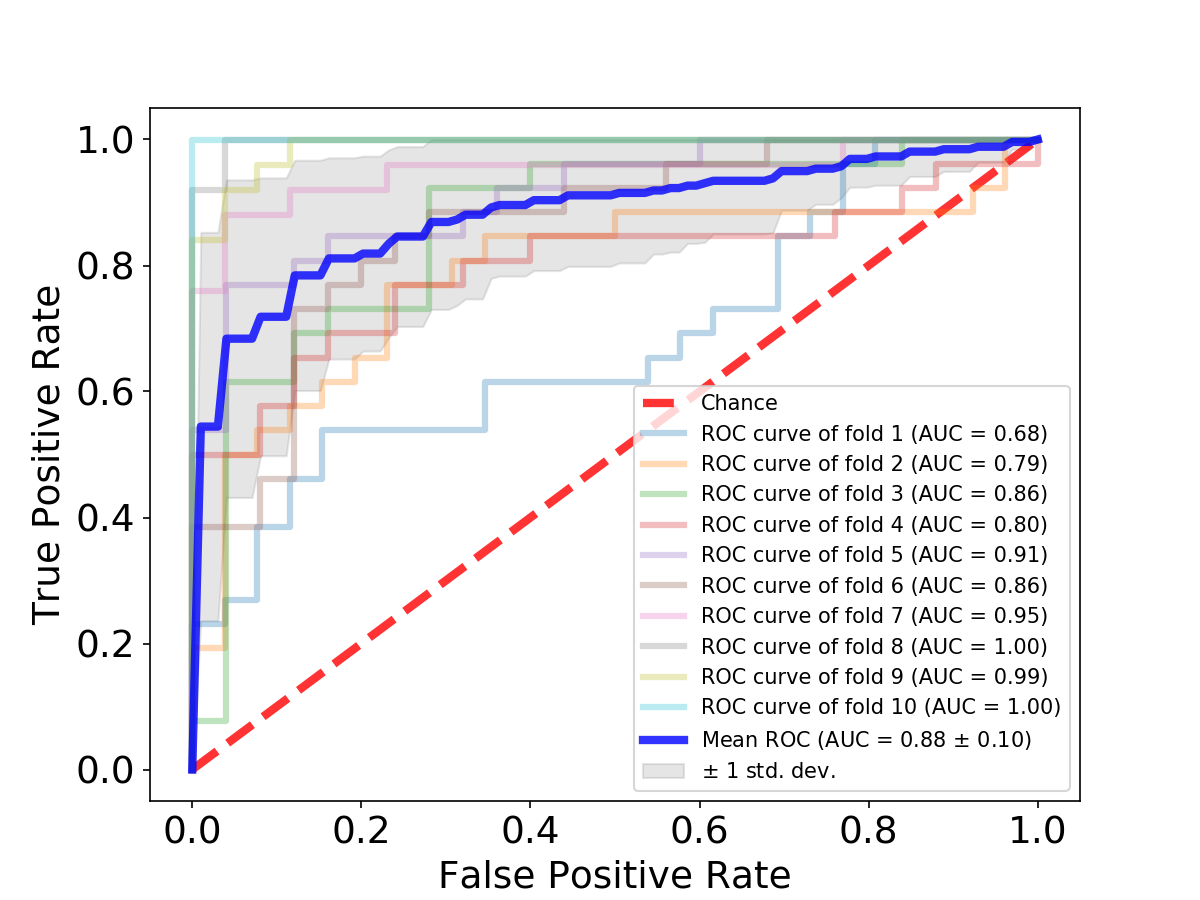

In [14]:
fig, ax = plt.subplots(figsize = (8,6))

ax.plot([0, 1], [0, 1], linestyle='--', color='r',
        label='Chance', alpha=.8, linewidth = 4)

for j in range(10):
    ax.plot(fprs[j], tprs[j], label='ROC curve of fold {0} (AUC = {1:0.2f})'.format(j+1, aucs[j]), alpha=0.3, linewidth = 3)

mean_fpr = np.linspace(0, 1, 100)
mean_tpr = np.mean(tprs_all, axis=0)
mean_tpr[-1] = 1.0
mean_auc_svm = auc(mean_fpr, mean_tpr)
std_auc_svm = np.std(aucs)
ax.plot(mean_fpr, mean_tpr, color='b',
        label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc_svm, std_auc_svm),
        alpha=.8, linewidth = 4)

std_tpr = np.std(tprs_all, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
ax.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                label=r'$\pm$ 1 std. dev.')
ax.set(xlim=[-0.05, 1.05], ylim=[-0.05, 1.05])

ax.legend(loc="lower right")

plt.xlabel('False Positive Rate', fontsize=18)
plt.ylabel('True Positive Rate', fontsize=18)
plt.legend(loc="lower right", prop={"size":10})
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.savefig('maccs_D_zfnet.pdf',dpi=600)
plt.show()